In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

In [2]:
# Define data transformations (normalize to [0,1])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the data
data_train_and_val = MNIST("mnist_data", download=True, transform=transform)
train_size = int(0.9*len(data_train_and_val))
data_train, data_val = random_split(data_train_and_val, [train_size, len(data_train_and_val)- train_size])
data_test = MNIST("mnist_data_val", train=False, download=True, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.16MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 415kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 996kB/s]
100%|██████████| 9.91M/9.91M [00:01<00:00, 6.37MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 324kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.26MB/s]


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # (28x28) -> (28x28)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (28x28) -> (28x28)
        self.pool = nn.MaxPool2d(2, 2)  # (28x28) -> (14x14)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # No softmax (handled in loss function)

model = CNN()

In [4]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = np.inf

epochs = 5
for epoch in range(epochs):

    model.train() # Set model in training mode
    loss_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    
    loss_train /= len(train_loader) # Average error 

    model.eval() # Set model in evaluation mode
    loss_val = 0
    correct, total = 0,0
    with torch.no_grad():
        for images,labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_val += loss.item()

            _, pred = torch.max(outputs,1)
            total += labels.size(0)
            correct += (pred==labels).sum().item()
    
    loss_val /= len(val_loader)
    acc_val = 100 * correct/total

    print(f"Epoch {epoch+1}: Train Loss = {loss_train:.4f}, Val Loss = {loss_val:.4f}, Val Acc = {acc_val:.2f}%")


    # Save best model
    if loss_val < best_val_loss:
        best_val_loss = loss_val
        torch.save(model.state_dict(), "best_cnn_mnist.pth")


Epoch 1: Train Loss = 0.1536, Val Loss = 0.0516, Val Acc = 98.40%
Epoch 2: Train Loss = 0.0441, Val Loss = 0.0376, Val Acc = 98.83%
Epoch 3: Train Loss = 0.0273, Val Loss = 0.0359, Val Acc = 98.82%
Epoch 4: Train Loss = 0.0185, Val Loss = 0.0417, Val Acc = 98.83%
Epoch 5: Train Loss = 0.0125, Val Loss = 0.0390, Val Acc = 98.97%


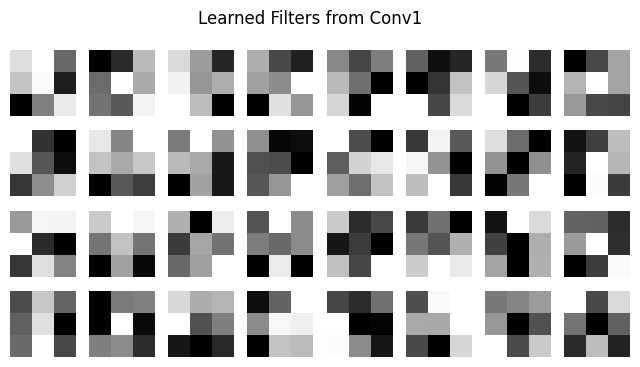

In [5]:
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load("best_cnn_mnist.pth"))
model.eval()

# Get the weights from the first convolutional layer
filters = model.conv1.weight.data  # Shape: (32, 1, 3, 3) -> 32 filters of size 3x3

# Normalize for visualization
filters = (filters - filters.min()) / (filters.max() - filters.min())

# Plot filters
fig, axes = plt.subplots(4, 8, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    if i < filters.shape[0]:  # Ensure we don't go out of bounds
        ax.imshow(filters[i, 0].cpu().numpy(), cmap="gray")  # Convert to NumPy
        ax.axis("off")
plt.suptitle("Learned Filters from Conv1")
plt.show()


In [6]:
import numpy as np

def visualize_feature_maps(model, image):
    model.eval()

    # Convert image to a batch (add batch dimension)
    image = image.unsqueeze(0)  # Shape: (1, 1, 28, 28)

    # Forward pass through only the first conv layer
    with torch.no_grad():
        activation = model.conv1(image)  # Shape: (1, 32, 28, 28)

    # Normalize activation maps for visualization
    activation = activation.squeeze(0).cpu().numpy()  # Remove batch dim -> (32, 28, 28)
    activation = (activation - activation.min()) / (activation.max() - activation.min())

    # Plot feature maps
    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        if i < activation.shape[0]:  # Ensure we don't exceed available filters
            ax.imshow(activation[i], cmap="gray")
            ax.axis("off")
    plt.suptitle("Feature Maps from Conv1")
    plt.show()

    # Forward pass through only the second conv layer
    # Forward pass through the first conv layer, second conv layer, and pooling
    with torch.no_grad():
        x = model.conv1(image)  # After first conv: Shape (1, 32, 28, 28)
        x = torch.relu(x)  # Apply ReLU activation
        x = model.conv2(x)  # After second conv: Shape (1, 64, 28, 28)
        x = torch.relu(x)  # Apply ReLU activation
        x = model.pool(x)  # After max-pooling: Shape (1, 64, 14, 14)

    # Normalize activation maps for visualization
    activation = x.squeeze(0).cpu().numpy()  # Remove batch dim -> (32, 28, 28)
    activation = (activation - activation.min()) / (activation.max() - activation.min())

    # Plot feature maps
    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        if i < activation.shape[0]:  # Ensure we don't exceed available filters
            ax.imshow(activation[i], cmap="gray")
            ax.axis("off")
    plt.suptitle("Feature Maps from Conv2")
    plt.show()


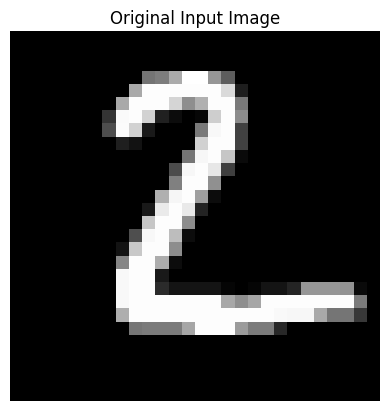

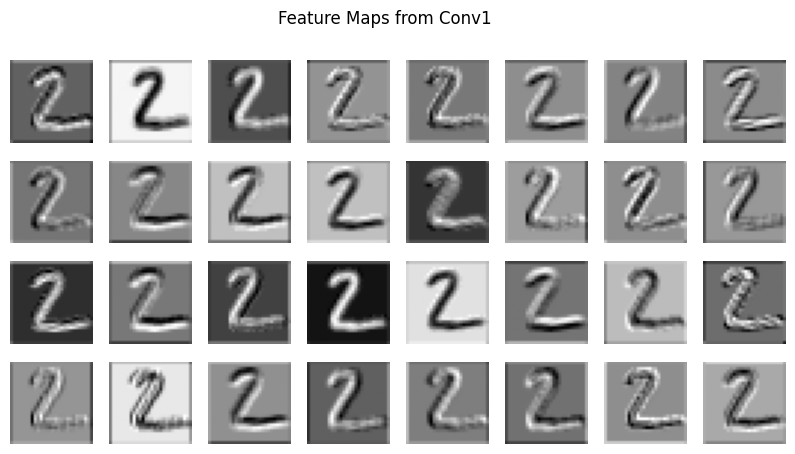

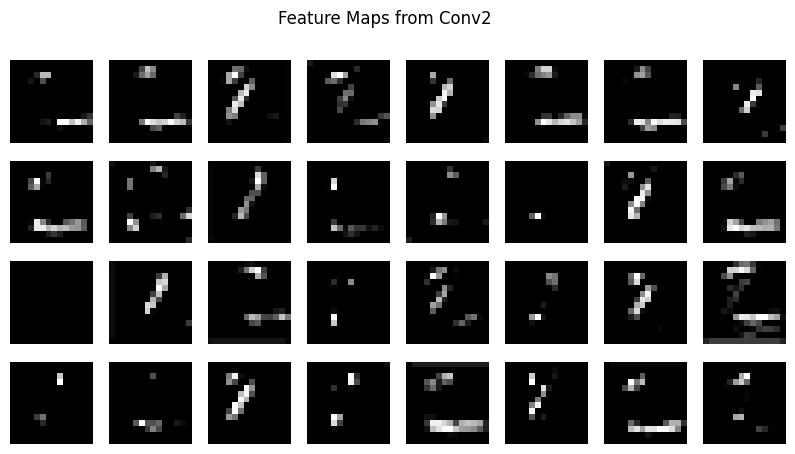

In [7]:
# Select an image from the test dataset
sample_image, _ = data_test[1]  # Get image only (ignore label)
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.title("Original Input Image")
plt.axis("off")
plt.show()

# Visualize feature maps
visualize_feature_maps(model, sample_image)


In [8]:
from sklearn.decomposition import PCA

# Get the logits (output from the final fully connected layer) for all test data points
logits = []
labels = []

# Put model in evaluation mode
model.eval()

with torch.no_grad():
    for images, targets in test_loader:
        outputs = model(images)  # Get raw logits (before softmax)
        logits.append(outputs.cpu().numpy())  # Store logits
        labels.append(targets.cpu().numpy())  # Store labels

logits = np.concatenate(logits, axis=0)  # Shape: (num_samples, 10)
labels = np.concatenate(labels, axis=0)  # Shape: (num_samples,)


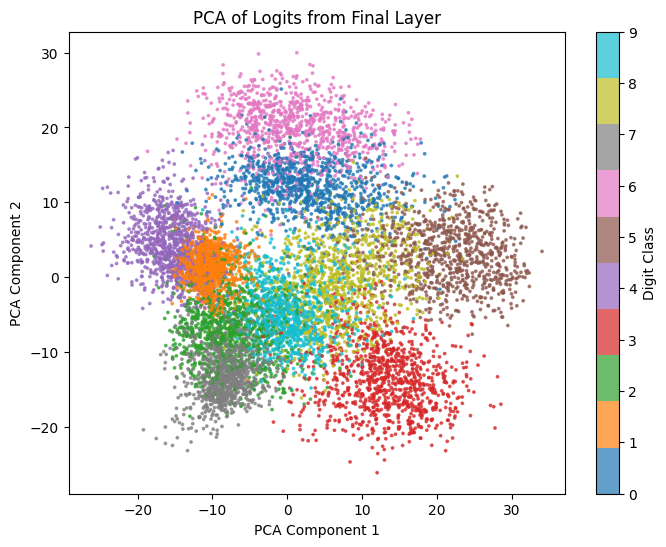

In [9]:
# Apply PCA for dimensionality reduction (10 -> 2)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(logits)

# Visualize with scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap="tab10", alpha=0.7, s=3)
plt.colorbar(label="Digit Class")
plt.title("PCA of Logits from Final Layer")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
